In [1]:
%load_ext autoreload
%autoreload

In [2]:
import pandas as pd
import geopandas as gpd
import shapely
import nomad.io.base as loader
import numpy as np
import nomad.stop_detection.hdbscan as HDBSCAN
import nomad.stop_detection.lachesis as LACHESIS
import nomad.stop_detection.ta_dbscan as TADBSCAN
from functools import partial

from nomad.stop_detection.utils import summarize_stop

import geopandas as gpd
import nomad.visit_attribution as visits
import nomad.filters as filters
from nomad.contact_estimation import overlapping_visits, compute_visitation_errors, compute_precision_recall_f1
import matplotlib.pyplot as plt

In [3]:
traj_cols = {'user_id':'uid',
             'x':'x',
             'y':'y',
             'timestamp':'timestamp'}
poi_table = gpd.read_file('../garden_city.gpkg')

diaries_df = loader.from_file("../../nomad/data/diaries", format="parquet", traj_cols=traj_cols,
                       parse_dates=True)
diaries_df = diaries_df.rename({'location':'building_id'}, axis=1)

sparse_df = loader.from_file("../../nomad/data/sparse_traj/", format="parquet", traj_cols=traj_cols,
                      parse_dates=True)

# longitude and latitude are also broken!
sparse_df.loc[:,'x'] = sparse_df['x'] - 2*(4265699)
sparse_df.loc[:,'y'] = sparse_df['y'] + 2*(4392976)

diaries_df.loc[:,'x'] = diaries_df['x'] - 2*(4265699)
diaries_df.loc[:,'y'] = diaries_df['y'] + 2*(4392976)

## Analyze completeness

In [4]:
completeness_df = filters.q_stats(sparse_df, traj_cols=traj_cols)

In [5]:
completeness_df.q_stat.quantile([0.5, 0.7, 0.85])

0.50    0.381897
0.70    0.490051
0.85    0.578152
Name: q_stat, dtype: float64

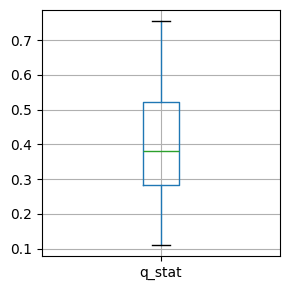

In [6]:
plt.figure(figsize=(3,3))
completeness_df.boxplot(column="q_stat")
plt.grid(True)
plt.tight_layout()

plt.show()

## Example for one user

In [7]:
# Select data from 1 user
user1 = diaries_df.uid.unique()[0]

sparse1 = sparse_df.loc[sparse_df['uid'] == user1]
diary1 = diaries_df.loc[diaries_df.uid == user1]

In [8]:
help(summarize_stop)

Help on function summarize_stop in module nomad.stop_detection.utils:

summarize_stop(grouped_data, method='medoid', complete_output=False, keep_col_names=True, passthrough_cols=None, traj_cols=None, **kwargs)



In [9]:
%%time
DUR_MIN=5
DT_MAX=90
DELTA_ROAM=30
# to summarize stops after groupby passing through individual locations
summarize_stops_with_loc = partial(summarize_stop, x='x', y='y', keep_col_names=False, passthrough_cols = ['building_id']) # < function(grouped_data)

# If we want to use 'majority' to attribute visits, then we need stop labels on each ping
labels_lachesis = LACHESIS._lachesis_labels(traj=sparse1,
                                            dur_min=DUR_MIN,
                                            dt_max=DT_MAX,
                                            delta_roam=DELTA_ROAM,
                                            traj_cols=traj_cols)
labels_lachesis.name = 'cluster'
# join with the original data
sparse_with_cluster = sparse1.join(labels_lachesis)

# has same index as data
pred_lachesis = visits.point_in_polygon(data=sparse_with_cluster,
                                        poi_table=poi_table,
                                        method='majority',
                                        data_crs='EPSG:3857',
                                        max_distance=10,
                                        cluster_label='cluster',
                                        location_id='building_id',
                                        x='x',
                                        y='y')
# join the building id
pred = sparse_with_cluster.join(pred_lachesis)

stop_table_lachesis = pred[pred.cluster!=-1].groupby('cluster', as_index=False).apply(summarize_stops_with_loc)
stop_table_lachesis.head()

CPU times: total: 93.8 ms
Wall time: 106 ms


<timed exec>:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


,cluster,x,y,start_timestamp,end_timestamp,duration,building_id
0,0,-4.265482e+06,4.393187e+06,1704148860,1704150900,34,h-x15-y13
1,1,-4.265481e+06,4.393196e+06,1704151080,1704151560,8,h-x13-y13
2,2,-4.265498e+06,4.393192e+06,1704158220,1704164040,97,h-x13-y13
3,3,-4.265481e+06,4.393194e+06,1704164820,1704170160,89,h-x13-y13
4,4,-4.265483e+06,4.393128e+06,1704220020,1704222420,40,h-x13-y9


In [10]:
%%time
user1 = diaries_df.uid.unique()[0]
sparse1 = sparse_df.loc[sparse_df['uid'] == user1]
diary1 = diaries_df.loc[diaries_df.uid == user1]

TIME_THRESH=90

# If we want to use 'centroid' to attribute visits, then we can use either a stop table or the labels
_, stop_table_hdbscan = HDBSCAN.st_hdbscan(
                traj=sparse1,
                traj_cols=traj_cols,
                time_thresh=TIME_THRESH,
                min_pts=2,
                min_cluster_size=3)


pred_hdbscan = visits.point_in_polygon(data=stop_table_hdbscan,
                                        poi_table=poi_table,
                                        method='centroid',
                                        data_crs='EPSG:3857',
                                        max_distance=10,
                                        cluster_label='cluster',
                                        location_id='building_id',
                                        x='x',
                                        y='y')

stop_table_hdbscan = stop_table_hdbscan.join(pred_hdbscan)
stop_table_hdbscan.head()

C:\Users\franc\Documents\Nomad\nomad-repo\nomad\io\base.py:57: UserWarning: Trajectory column 'datetime' specified for 'datetime' not found in DataFrame.
  warnings.warn(f"Trajectory column '{value}' specified for '{key}' not found in DataFrame.")
C:\Users\franc\Documents\Nomad\nomad-repo\nomad\io\base.py:57: UserWarning: Trajectory column 'start_datetime' specified for 'start_datetime' not found in DataFrame.
  warnings.warn(f"Trajectory column '{value}' specified for '{key}' not found in DataFrame.")
C:\Users\franc\Documents\Nomad\nomad-repo\nomad\io\base.py:57: UserWarning: Trajectory column 'end_datetime' specified for 'end_datetime' not found in DataFrame.
  warnings.warn(f"Trajectory column '{value}' specified for '{key}' not found in DataFrame.")
C:\Users\franc\Documents\Nomad\nomad-repo\nomad\io\base.py:57: UserWarning: Trajectory column 'start_timestamp' specified for 'start_timestamp' not found in DataFrame.
  warnings.warn(f"Trajectory column '{value}' specified for '{key}' 

CPU times: total: 5.98 s
Wall time: 5.99 s


,cluster,start_timestamp,duration,x,y,building_id
0,1,1704148860,45,-4.265481e+06,4.393192e+06,h-x13-y13
1,2,1704158220,199,-4.265484e+06,4.393195e+06,h-x13-y13
2,3,1704216600,97,-4.265486e+06,4.393120e+06,h-x13-y9
3,4,1704253920,227,-4.265627e+06,4.393140e+06,w-x3-y10
4,5,1704287400,34,-4.265637e+06,4.393218e+06,w-x3-y16


In [11]:
%%time
traj_cols = {'user_id':'uid',
             'x':'x',
             'y':'y',
             'timestamp':'timestamp'}
stop_detection_algos = ['lachesis', 'ta-dbscan', 'hdbscan']
metrics_df = pd.DataFrame()
TIME_THRESH=240
DIST_THRESH=20
MIN_PTS=2

DUR_MIN=5
DT_MAX=240
DELTA_ROAM=30

for user in diaries_df.uid.unique()[:2]:
    sparse = sparse_df[sparse_df['uid'] == user].copy()
    truth = diaries_df.loc[diaries_df['uid'] == user].copy()

    for algo in stop_detection_algos:
        if algo == 'lachesis':
            labels = LACHESIS._lachesis_labels(
                traj=sparse,
                dur_min=DUR_MIN,
                dt_max=DT_MAX,
                delta_roam=DELTA_ROAM,
                traj_cols=traj_cols)
            
            labels.name = 'cluster'           
            sparse_with_cluster = sparse.join(labels)
            
        elif algo == 'ta-dbscan':
            labels = TADBSCAN._temporal_dbscan_labels(
                data=sparse,
                time_thresh=TIME_THRESH,
                dist_thresh=DIST_THRESH,
                min_pts=MIN_PTS,
                traj_cols=traj_cols)
            labels.name = 'cluster'
            sparse_with_cluster = sparse.join(labels)
            
        else:  # 'hdbscan'
            labels = HDBSCAN.hdbscan_labels(
                traj=sparse,
                time_thresh=TIME_THRESH,
                min_pts=2,
                min_cluster_size=3,
                traj_cols=traj_cols)
            labels.name = 'cluster'
            sparse_with_cluster = sparse.join(labels)

        pred = visits.point_in_polygon(data=sparse_with_cluster,
                                        poi_table=poi_table,
                                        method='majority',
                                        data_crs='EPSG:3857',
                                        max_distance=15,
                                        cluster_label='cluster',
                                        location_id='building_id',
                                        x='x',
                                        y='y')

        pred = sparse_with_cluster.join(pred)

        # Below methods need a stop table, so we summarize stops with location_id
        stops = pred[pred.cluster!=-1].groupby('cluster', as_index=False).apply(summarize_stops_with_loc)
        
        # Step 1: Compute overlaps
        overlaps = overlapping_visits(left=stops,
                                      right=truth,
                                      location_id='building_id',
                                      match_location=False)

        # Step 2: Compute visitation errors (missed, merged, split)
        errors = compute_visitation_errors(overlaps=overlaps,
                                           true_visits=truth,
                                           location_id='building_id')

        # Step 3: Compute precision, recall, and F1
        prf1 = compute_precision_recall_f1(overlaps=overlaps,
                                           pred_visits=stops,
                                           true_visits=truth,
                                           location_id='building_id')

        all_metrics = {**errors, **prf1, 'user': user, 'algorithm': algo}
        metrics_df = pd.concat([metrics_df, pd.DataFrame([all_metrics])], ignore_index=True)

<timed exec>:64: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
<timed exec>:64: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
<timed exec>:64: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly

CPU times: total: 23.2 s
Wall time: 23.1 s


<timed exec>:64: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [12]:
metrics_df

,missed_fraction,merged_fraction,split_fraction,precision,recall,f1,user,algorithm
0,0.907090,0.004890,0.024450,0.999041,0.150361,0.261382,admiring_curie,lachesis
1,0.921760,0.009780,0.000000,0.999287,0.151732,0.263460,admiring_curie,ta-dbscan
2,0.880196,0.088020,0.000000,0.978190,0.182828,0.308076,admiring_curie,hdbscan
3,0.908277,0.004474,0.020134,0.996347,0.127922,0.226734,adoring_keldysh,lachesis
4,0.906040,0.015660,0.002237,0.988946,0.138781,0.243404,adoring_keldysh,ta-dbscan
5,0.888143,0.089485,0.004474,0.968769,0.170094,0.289379,adoring_keldysh,hdbscan


In [13]:
metrics_df.groupby(['algorithm'])[['missed_fraction','merged_fraction','split_fraction','precision','recall','f1']].mean()

,missed_fraction,merged_fraction,split_fraction,precision,recall,f1
algorithm,,,,,,
hdbscan,0.884169,0.088753,0.002237,0.973479,0.176461,0.298727
lachesis,0.907684,0.004682,0.022292,0.997694,0.139141,0.244058
ta-dbscan,0.913900,0.012720,0.001119,0.994117,0.145256,0.253432


<Figure size 640x480 with 0 Axes>

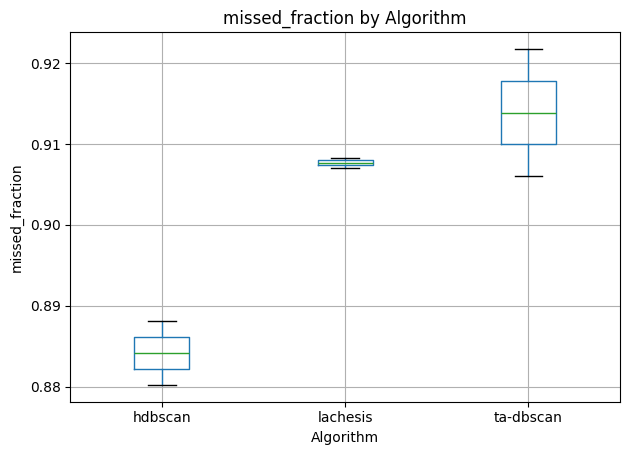

<Figure size 640x480 with 0 Axes>

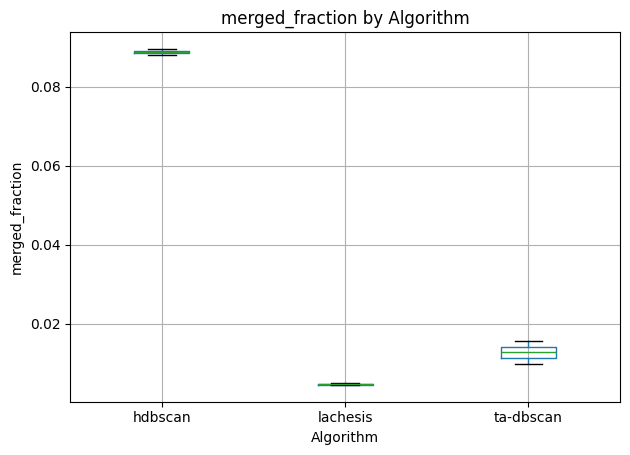

<Figure size 640x480 with 0 Axes>

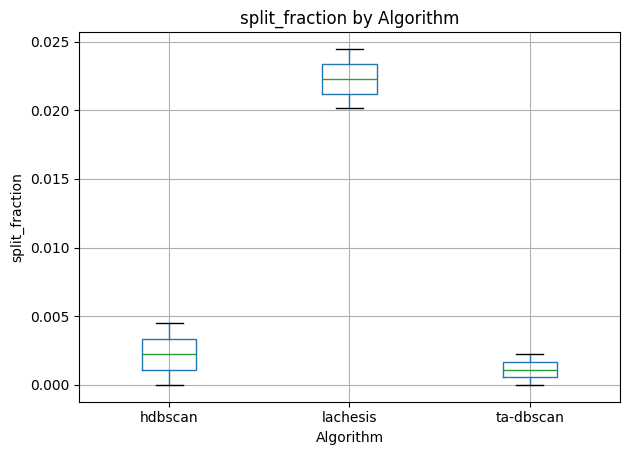

<Figure size 640x480 with 0 Axes>

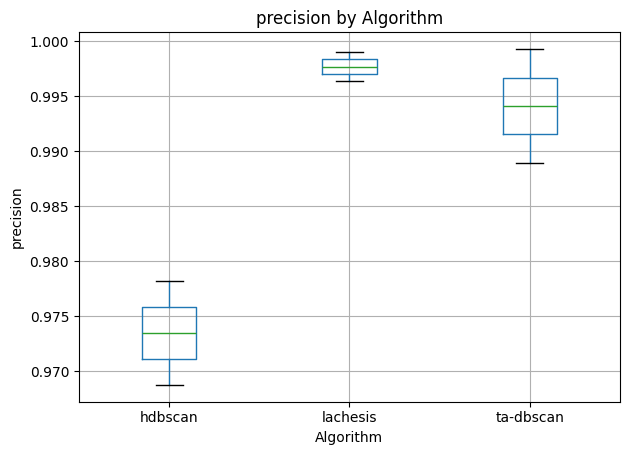

<Figure size 640x480 with 0 Axes>

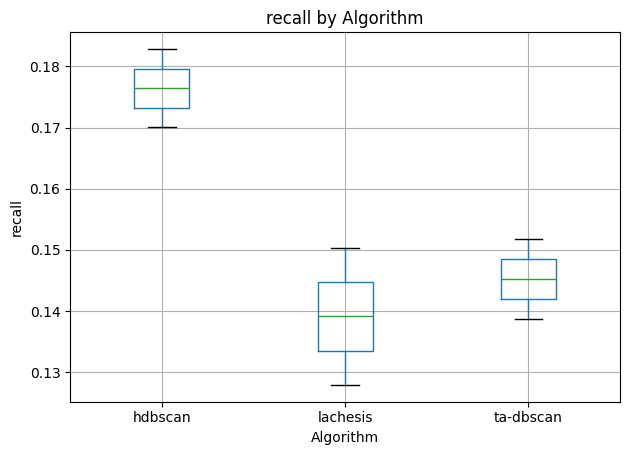

<Figure size 640x480 with 0 Axes>

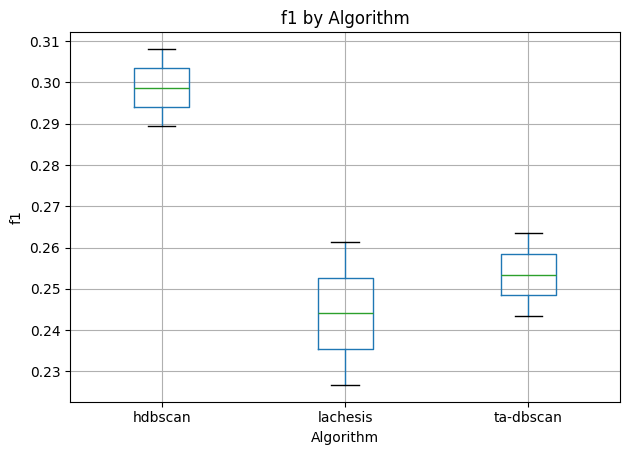

In [14]:
metrics = ["missed_fraction", "merged_fraction", "split_fraction", "precision", "recall", "f1"]

# metrics_df_no_lachesis = metrics_df.copy()
# metrics_df_no_lachesis = metrics_df_no_lachesis[metrics_df_no_lachesis['algorithm'] != 'lachesis']

for metric in metrics:
    plt.figure()
    metrics_df.boxplot(column=metric, by='algorithm')
    # metrics_df_no_lachesis.boxplot(column=metric, by='algorithm')
    plt.title(f'{metric} by Algorithm')
    plt.suptitle('')
    plt.xlabel('Algorithm')
    plt.ylabel(metric)
    plt.grid(True)
    plt.tight_layout()

plt.show()

In [15]:
import nomad.city_gen as cg
city = cg.load('../garden-city.pkl')

def classify_building(building):
    n_blocks = len(building.blocks)
    if n_blocks == 1:
        return 'small'
    elif 2 <= n_blocks <= 3:
        return 'medium'
    else:
        return 'big'

building_sizes = {
    b_id: classify_building(b_obj)
    for b_id, b_obj in city.buildings.items()
}

building_sizes

def clasify_dwell(stop_table):
    # (low, mid, high)
    return

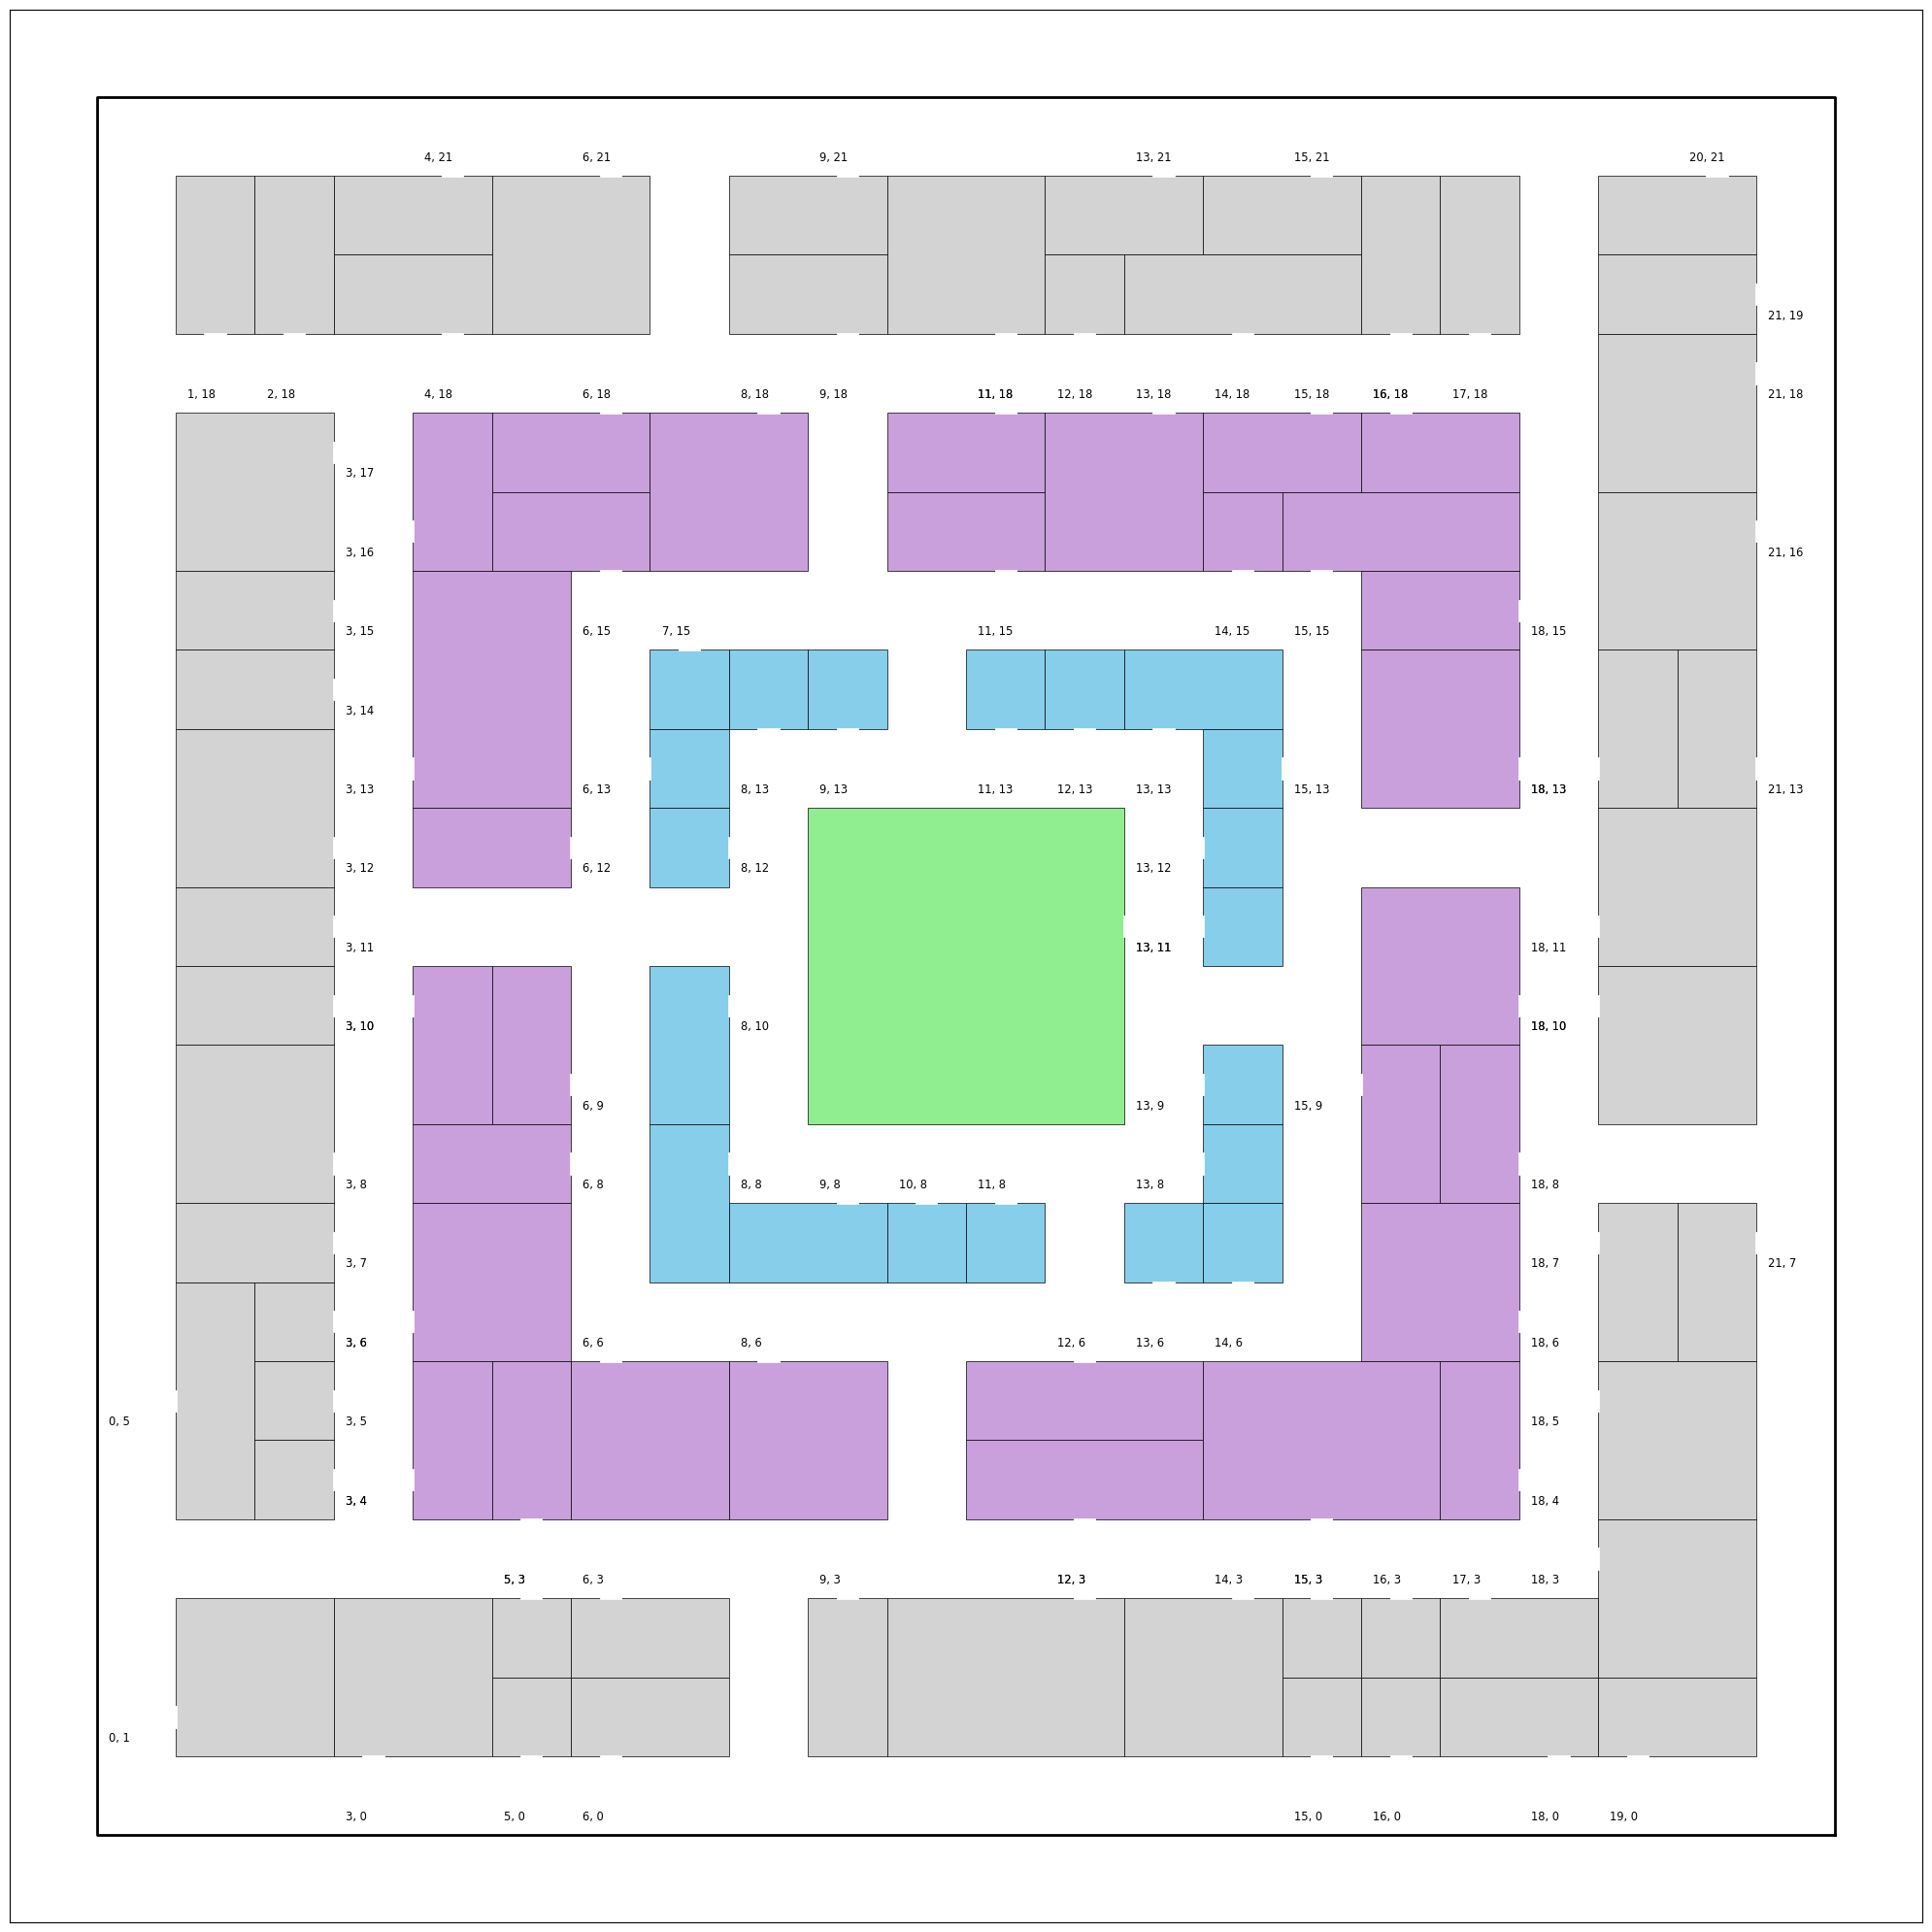

In [16]:
fig, ax = plt.subplots(figsize=(20, 20))
plt.box(on=True)

# Plotting Garden City Map

city.plot_city(ax, doors=True, address=True)

ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
plt.show()

In [17]:
city.buildings['r-x5-y0'].blocks

[(5, 1)]

In [18]:
city.buildings

{'p-x13-y11': <nomad.city_gen.Building at 0x1a826b3ce80>,
 'h-x8-y8': <nomad.city_gen.Building at 0x1a826b3cf10>,
 'h-x9-y8': <nomad.city_gen.Building at 0x1a826b3dcf0>,
 'h-x10-y8': <nomad.city_gen.Building at 0x1a826b3dbd0>,
 'h-x11-y8': <nomad.city_gen.Building at 0x1a826b3dcc0>,
 'h-x13-y6': <nomad.city_gen.Building at 0x1a826b3e7d0>,
 'h-x14-y6': <nomad.city_gen.Building at 0x1a8269779d0>,
 'h-x13-y8': <nomad.city_gen.Building at 0x1a826975000>,
 'h-x13-y9': <nomad.city_gen.Building at 0x1a826975030>,
 'h-x13-y11': <nomad.city_gen.Building at 0x1a826974c40>,
 'h-x13-y12': <nomad.city_gen.Building at 0x1a8269761a0>,
 'h-x15-y13': <nomad.city_gen.Building at 0x1a8269760e0>,
 'h-x13-y13': <nomad.city_gen.Building at 0x1a826977100>,
 'h-x12-y13': <nomad.city_gen.Building at 0x1a826977b20>,
 'h-x11-y13': <nomad.city_gen.Building at 0x1a826977850>,
 'h-x9-y13': <nomad.city_gen.Building at 0x1a8269770a0>,
 'h-x8-y13': <nomad.city_gen.Building at 0x1a826977580>,
 'h-x7-y15': <nomad.city_g